In [78]:
''' importing library''' 

import numpy as np
import sys
import tensorflow as tf
import os
import sys
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [79]:
'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [80]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [81]:
'''test1, train Data is in current working folder'''
print(os.listdir('./'))

['.ipynb_checkpoints', 'dogs-vs-cats', 'dogs-vs-cats.zip', 'sampleSubmission.csv', 'test1', 'train', 'Untitled.ipynb', 'Untitled1.ipynb']


In [82]:
IMAGE_FOLDER_PATH = "./train/"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)
WIDTH = 150
HEIGHT = 150

In [83]:
FILE_NAMES[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [84]:
# empty list
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [85]:
dataset.target.value_counts()

cat    12500
dog    12500
Name: target, dtype: int64

In [86]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
cat    12500
dog    12500
Name: target, dtype: int64


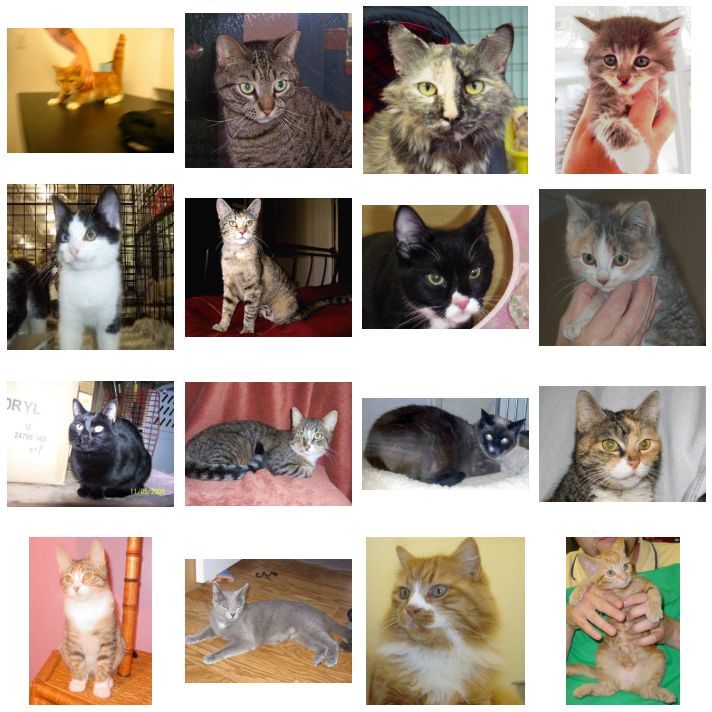

In [87]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_cats_dir[i])
    sp = fig.add_subplot(rows,cols,a+1);
    axes.append(sp);
    sp.axis('off');
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

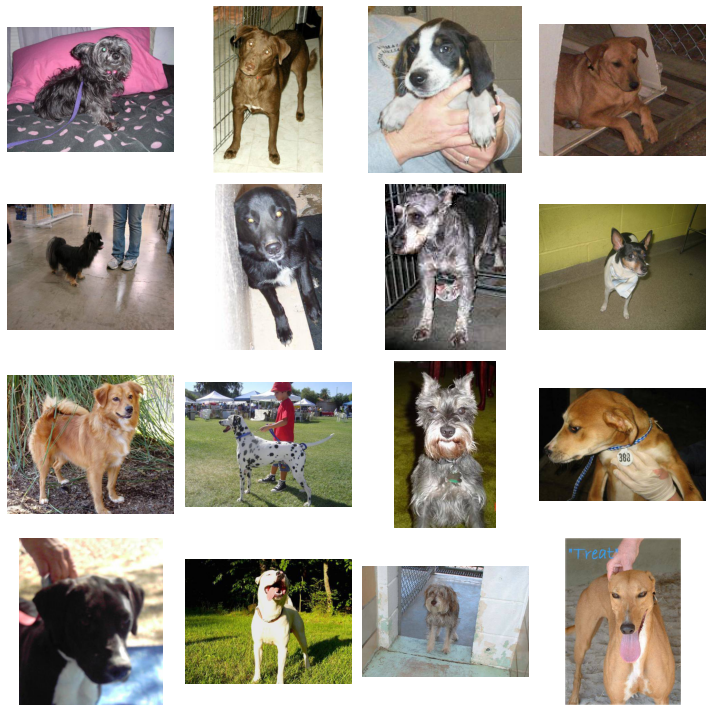

In [88]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_dogs_dir[i])
    sp = fig.add_subplot(rows,cols,a+1);
    axes.append(sp);
    sp.axis('off');
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

In [89]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=seed)

In [90]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [91]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [92]:
def create_model():

    model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 

    return model

In [93]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 64)      

In [94]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
print("[INFO]: model compiled...")

[INFO]: model compiled...


In [95]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            self.model.stop_training = True
            
callback = mycallback()

In [96]:
modelHistory=model.fit(train_datagenerator,
                       epochs=50,
                       validation_data=test_datagenerator,
                       validation_steps=dataset_test.shape[0]/150,
                       steps_per_epoch=dataset_train.shape[0]/150,
                       callbacks=[callback])

Epoch 1/50
133/133 [==============================] - 253s 2s/step - loss: 0.6368 - accuracy: 0.6291 - val_loss: 0.5437 - val_accuracy: 0.7240
Epoch 2/50
133/133 [==============================] - 172s 1s/step - loss: 0.5442 - accuracy: 0.7247 - val_loss: 0.5079 - val_accuracy: 0.7474
Epoch 3/50
133/133 [==============================] - 172s 1s/step - loss: 0.5201 - accuracy: 0.7419 - val_loss: 0.4581 - val_accuracy: 0.7784
Epoch 4/50
133/133 [==============================] - 171s 1s/step - loss: 0.4733 - accuracy: 0.7720 - val_loss: 0.4137 - val_accuracy: 0.8080
Epoch 5/50
133/133 [==============================] - 164s 1s/step - loss: 0.4555 - accuracy: 0.7843 - val_loss: 0.4208 - val_accuracy: 0.8072
Epoch 6/50
133/133 [==============================] - 167s 1s/step - loss: 0.4263 - accuracy: 0.8031 - val_loss: 0.3931 - val_accuracy: 0.8210
Epoch 7/50
133/133 [==============================] - 172s 1s/step - loss: 0.4176 - accuracy: 0.8080 - val_loss: 0.3737 - val_accuracy: 0.8316

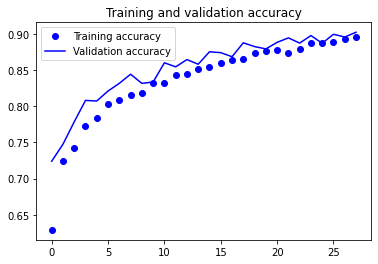

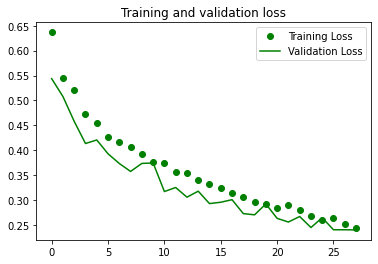

In [97]:
acc = modelHistory.history['accuracy']
val_acc = modelHistory.history['val_accuracy']
loss = modelHistory.history['loss']
val_loss = modelHistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [99]:
model.save('Model_Dogs&Cats')

INFO:tensorflow:Assets written to: Model_Dogs&Cats\assets


In [ ]:
model.predict(test_datagenerator)

In [100]:
dataset

,image_path,target
0,./train/cat.0.jpg,cat
1,./train/cat.1.jpg,cat
2,./train/cat.10.jpg,cat
3,./train/cat.100.jpg,cat
4,./train/cat.1000.jpg,cat
...,...,...
24995,./train/dog.9995.jpg,dog
24996,./train/dog.9996.jpg,dog
24997,./train/dog.9997.jpg,dog
24998,./train/dog.9998.jpg,dog


In [101]:
# train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
#                                                      x_col="image_path",
#                                                      y_col="target",
#                                                      target_size=(WIDTH, HEIGHT),
#                                                      class_mode="binary",
#                                                      batch_size=150)

In [109]:
print(len(os.listdir('test1/')))
test_files = os.listdir('test1/')
print(test_files[:3])
id_strings = [name.split('.')[0] for name in os.listdir('test1/')]
test_ids = list(map(int, id_strings))
test_ids.sort()
# print(test_ids) # it looks like test_ids - ie. the numbers in the test image file names - is simply a list from 1 thru 12500
print(min(test_ids))
print(max(test_ids))
sorted_id_strings = [('test1/'+str(test_id)+'.jpg') for test_id in test_ids]
print(sorted_id_strings[:10])

12500
['1.jpg', '10.jpg', '100.jpg']
1
12500
['test1/1.jpg', 'test1/2.jpg', 'test1/3.jpg', 'test1/4.jpg', 'test1/5.jpg', 'test1/6.jpg', 'test1/7.jpg', 'test1/8.jpg', 'test1/9.jpg', 'test1/10.jpg']


In [110]:
test_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [112]:
%matplotlib inline

import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

import tensorflow as tf
from tensorflow.keras import utils
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

test1/1.jpg
0.9519378
Dog


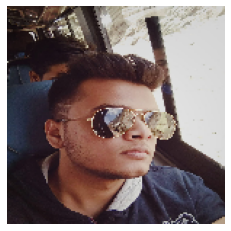


test1/2.jpg
0.9987734
Dog


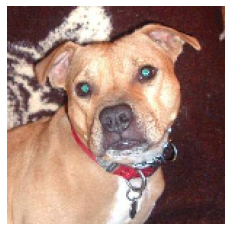


test1/3.jpg
0.91185904
Dog


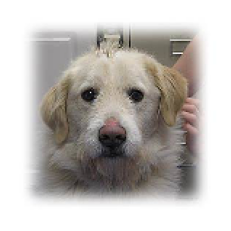


test1/4.jpg
0.9988859
Dog


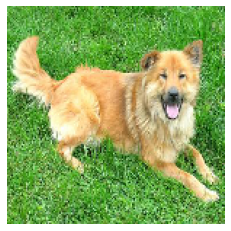


test1/5.jpg
0.002021104
Cat


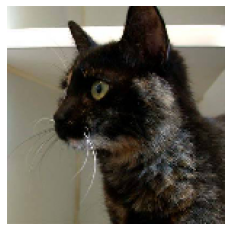


test1/6.jpg
0.09914857
Cat


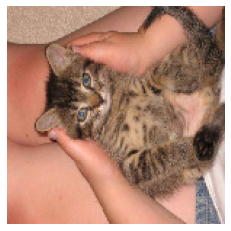


test1/7.jpg
0.00013703108
Cat


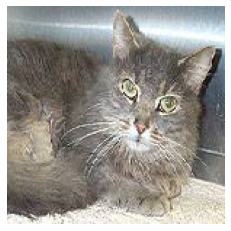


test1/8.jpg
0.26881146
Cat


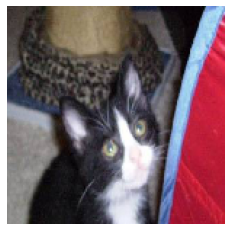


test1/9.jpg
0.0035544038
Cat


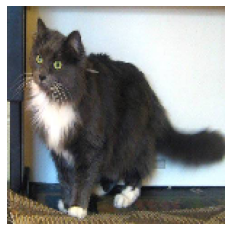


test1/10.jpg
0.0032648742
Cat


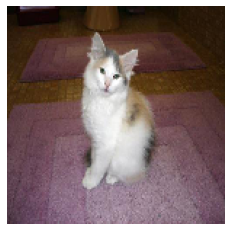

In [116]:
for name in sorted_id_strings[:10]:
    img = image.load_img(name, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.divide(x, 255.0)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images)
    print(name)
    print(classes[0][0])
    if classes[0][0]>0.5:
        print("Dog")
    else:
        print("Cat")
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    print()